In [1]:
# Import dependencies
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.combine import SMOTEENN
from collections import Counter

# Read CSV

In [2]:
# Load structures data
merge = pd.read_csv("Resources/clean_data/merge.csv")
print(merge.shape)
merge.head()

(1091, 71)


,SAMPLE_ID,STRUCTURE_ID,PREFERRED_LCMS_METHOD,SPE_METHOD,METHOD,SPE_SUCCESSFUL,CRASHED_OUT,SAMPLE_STATUS,SAMPLE_CURRENT_STATUS,TERMINATION_CAUSE,...,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount
0,MTA0ST2022-051-001_S2,MTA0ST2022-051-001,Xbridge HpH,HLB,HLB/Xbridge HpH,True,NaN,Complete,Completed & Stored,NaN,...,1,2,4,2,9,2,0,1,1,3
1,MTA0ST2022-051-003_G1,MTA0ST2022-051-003,Xbridge HpH,MCX,MCX/Xbridge HpH,True,NaN,Complete,Completed & Stored,NaN,...,1,2,4,1,8,2,0,1,1,3
2,MTA0ST2022-051-004,MTA0ST2022-051-004,Gemini LpH,MCX,MCX/Gemini LpH,True,NaN,Complete,Completed & Stored,NaN,...,0,2,3,1,6,2,0,1,1,3
3,MTA0ST2022-051-005,MTA0ST2022-051-005,Gemini LpH,MCX,MCX/Gemini LpH,True,NaN,Complete,Completed & Stored,NaN,...,1,2,2,1,6,2,0,1,1,3
4,MTA0ST2022-051-006,MTA0ST2022-051-006,Xbridge HpH,MCX,MCX/Xbridge HpH,True,NaN,Complete,Completed & Stored,NaN,...,1,3,2,1,6,2,0,1,1,4


# Define Features and Target and Split and Scale Data

In [3]:
# Create features
X = merge.drop(columns = ["SAMPLE_ID", 
                       "STRUCTURE_ID",
                       "PREFERRED_LCMS_METHOD", 
                       "SPE_METHOD", 
                       "METHOD", 
                       "SPE_SUCCESSFUL", 
                       "CRASHED_OUT", 
                       "SAMPLE_STATUS", 
                       "SAMPLE_CURRENT_STATUS", 
                       "TERMINATION_CAUSE", 
                       "TERMINATION_STEP", 
                       "TERMINATION_DETAILS", 
                       "REACTION_SCALE_(mmol)", 
                       "SELECTED_FRACTIONS", 
                       "VOLUME_COLLECTED_(mL)", 
                       "TOTAL_FRACTIONS_COLLECTED", 
                       "RECOVERED_SAMPLE_DRY_MASS_(mg)", 
                       "PERCENT_YIELD", 
                       "%_PURITY_(BY_LCMS)", 
                       "PURIFICATION_COMMENTS",
                       "EXTRA_COMMENTS"])

# Create target
y = merge["SPE_METHOD"]

In [4]:
X.describe()

,MolWt,ExactMolWt,logP,HBD,HBA,TPSA,Flexibility,Rotatable Bonds,qed,HeavyAtomMolWt,...,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount
count,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,...,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000
mean,390.107102,389.674482,3.575146,1.278643,5.774519,70.774079,0.165605,5.246563,0.617345,370.428466,...,1.536205,3.192484,5.041247,1.278643,7.555454,4.196150,0.043996,0.331806,0.375802,3.949588
std,83.949167,83.788746,1.062014,0.862731,1.576936,21.890474,0.051668,2.365012,0.174272,79.907039,...,0.759841,0.861819,1.296836,0.862731,2.136059,1.941347,0.226437,0.561687,0.593482,0.847136
min,226.283000,226.121846,0.660200,0.000000,2.000000,16.130000,0.050000,1.000000,0.138213,212.171000,...,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,2.000000
25%,325.777000,325.126803,2.825500,1.000000,5.000000,55.870000,0.125000,3.000000,0.472609,309.186000,...,1.000000,3.000000,4.000000,1.000000,6.000000,3.000000,0.000000,0.000000,0.000000,3.000000
50%,375.351000,375.090518,3.678000,1.000000,6.000000,67.390000,0.166700,5.000000,0.642067,356.325000,...,2.000000,3.000000,5.000000,1.000000,7.000000,4.000000,0.000000,0.000000,0.000000,4.000000
75%,449.832000,448.628306,4.263000,2.000000,7.000000,83.120000,0.205100,7.000000,0.766516,429.322000,...,2.000000,4.000000,6.000000,2.000000,9.000000,5.000000,0.000000,1.000000,1.000000,4.000000
max,774.895000,774.238214,6.399000,4.000000,12.000000,164.500000,0.340400,16.000000,0.925780,737.599000,...,4.000000,5.000000,13.000000,4.000000,16.000000,12.000000,3.000000,4.000000,4.000000,10.000000


In [5]:
# Check balance of target values
y.value_counts()

MCX    901
HLB    190
Name: SPE_METHOD, dtype: int64

In [6]:
# # Normal train-test split
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [7]:
# Create StandardScaler instance
scaler = StandardScaler()

# Fit StandardScaler
X_scaler = scaler.fit(X)
X_scaled = X_scaler.transform(X)

# XGBoost Models

In [8]:
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score



In [9]:
# Create features
X = merge.drop(columns = ["SAMPLE_ID", 
                       "STRUCTURE_ID",
                       "PREFERRED_LCMS_METHOD", 
                       "SPE_METHOD", 
                       "METHOD", 
                       "SPE_SUCCESSFUL", 
                       "CRASHED_OUT", 
                       "SAMPLE_STATUS", 
                       "SAMPLE_CURRENT_STATUS", 
                       "TERMINATION_CAUSE", 
                       "TERMINATION_STEP", 
                       "TERMINATION_DETAILS", 
                       "REACTION_SCALE_(mmol)", 
                       "SELECTED_FRACTIONS", 
                       "VOLUME_COLLECTED_(mL)", 
                       "TOTAL_FRACTIONS_COLLECTED", 
                       "RECOVERED_SAMPLE_DRY_MASS_(mg)", 
                       "PERCENT_YIELD", 
                       "%_PURITY_(BY_LCMS)", 
                       "PURIFICATION_COMMENTS",
                       "EXTRA_COMMENTS"])

# Create target
y = merge["SPE_METHOD"]

In [10]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [11]:
# create model
model = XGBClassifier()
model.fit(X_train, y_train)

[21:11:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/yycheung/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
y_pred = model.predict(X_test)
predictions = [value for value in y_pred]

In [13]:
accuracy = accuracy_score(y_test, predictions)
accuracy

0.9194139194139194

In [14]:
# Calculated the accuracy score

from sklearn.metrics import balanced_accuracy_score
print(f"Balanced Accuracy score for XGBoost: {balanced_accuracy_score(y_test, predictions)}\n")


# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(f"\n {classification_report_imbalanced(y_test, predictions)}")

Balanced Accuracy score for XGBoost: 0.859830418653948


                    pre       rec       spe        f1       geo       iba       sup

        HLB       0.80      0.76      0.95      0.78      0.85      0.72        51
        MCX       0.95      0.95      0.76      0.95      0.85      0.74       222

avg / total       0.92      0.92      0.80      0.92      0.85      0.74       273



/Users/yycheung/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:11:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


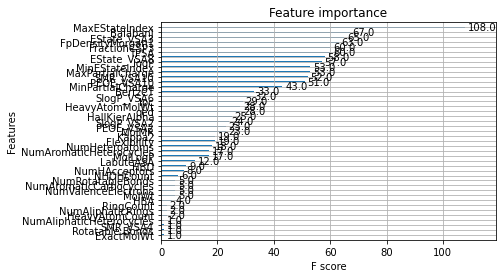

In [15]:
from xgboost import plot_importance
from matplotlib import pyplot

model.fit(X, y)
plot_importance(model)
pyplot.show()

In [16]:
# List features sorted in descending order by feature importance
importance = model.feature_importances_
bar_list = sorted(zip(importance, X.columns), reverse = True)
x=[]
y=[]
for i in bar_list:
    x.append(i[1])
    y.append(i[0])
    
bar_df = pd.DataFrame({
    'importance' : y,
    'features':x
    
})

bar_df

,importance,features
0,0.207527,NumValenceElectrons
1,0.138343,SMR_VSA10
2,0.082414,NumAromaticHeterocycles
3,0.044686,MinPartialCharge
4,0.044403,MaxPartialCharge
5,0.034944,MolLogP
6,0.032454,qed
7,0.032057,HBD
8,0.028133,HeavyAtomMolWt
9,0.027757,FractionCSP3


[Text(0, 0, 'NumValenceElectrons'),
 Text(1, 0, 'SMR_VSA10'),
 Text(2, 0, 'NumAromaticHeterocycles'),
 Text(3, 0, 'MinPartialCharge'),
 Text(4, 0, 'MaxPartialCharge'),
 Text(5, 0, 'MolLogP'),
 Text(6, 0, 'qed'),
 Text(7, 0, 'HBD'),
 Text(8, 0, 'HeavyAtomMolWt'),
 Text(9, 0, 'FractionCSP3'),
 Text(10, 0, 'MolWt'),
 Text(11, 0, 'logP'),
 Text(12, 0, 'SlogP_VSA6'),
 Text(13, 0, 'HallKierAlpha'),
 Text(14, 0, 'RingCount'),
 Text(15, 0, 'TPSA'),
 Text(16, 0, 'NumAliphaticHeterocycles'),
 Text(17, 0, 'PEOE_VSA10'),
 Text(18, 0, 'Rotatable Bonds'),
 Text(19, 0, 'MinEStateIndex'),
 Text(20, 0, 'BertzCT'),
 Text(21, 0, 'FpDensityMorgan1'),
 Text(22, 0, 'EState_VSA3'),
 Text(23, 0, 'Flexibility'),
 Text(24, 0, 'MolMR'),
 Text(25, 0, 'NumRotatableBonds'),
 Text(26, 0, 'SlogP_VSA2'),
 Text(27, 0, 'EState_VSA8'),
 Text(28, 0, 'NumHAcceptors'),
 Text(29, 0, 'MaxEStateIndex'),
 Text(30, 0, 'HBA'),
 Text(31, 0, 'BalabanJ'),
 Text(32, 0, 'NumHeteroatoms'),
 Text(33, 0, 'Kappa2'),
 Text(34, 0, 'PEOE_VSA

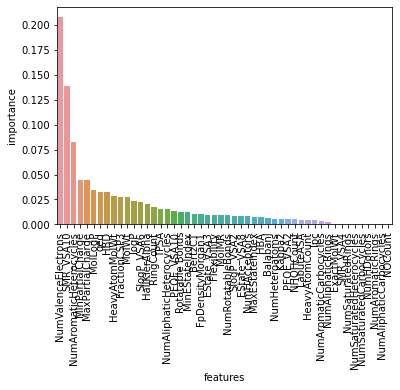

In [17]:
import seaborn as sns

ax = sns.barplot(x = 'features', y = 'importance', data = bar_df )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)